In [1]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")

In [2]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import data_processing, compute_anomalies_and_scalers, \
                            compute_forced_response, \
                            numpy_to_torch, rescale_and_merge_training_and_test_sets, \
                            rescale_training_and_test_sets


from plot_tools import plot_gt_vs_pred, animation_gt_vs_pred
from leave_one_out import leave_one_out_single, leave_one_out_procedure
from cross_validation import cross_validation_procedure

In [3]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [4]:
# define pytorch precision
dtype = torch.float32

data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat,max_models=100)
x, means, vars = compute_anomalies_and_scalers(data_processed, lon_size, lat_size, nan_idx, time_period=34)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=34)

x,y, means, vars = numpy_to_torch(x,y,means,vars, dtype=dtype)

/home/vcohen/cope/src/preprocessing.py:90: RuntimeWarning: Mean of empty slice
  means[m] = np.nanmean(data_reshaped[m],axis=0)
/home/vcohen/cope/src/preprocessing.py:93: RuntimeWarning: Degrees of freedom <= 0 for slice.
  vars[m] = np.nanvar(data_reshaped[m],axis=0)
/home/vcohen/cope/src/preprocessing.py:127: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)


In [5]:
m0= 'ICON-ESM-LR'
m1 ='EC-Earth3'
training_models_tmp, x_rescaled_tmp, y_rescaled_tmp = rescale_training_and_test_sets(m1,x,y,means,vars,dtype=dtype)
training_models, x_rescaled, y_rescaled = rescale_training_and_test_sets(m0,x,y,means,vars,dtype=dtype)
training_models, x_train, y_train, x_test, y_test = rescale_and_merge_training_and_test_sets(m0,x,y,means,vars,dtype=dtype)

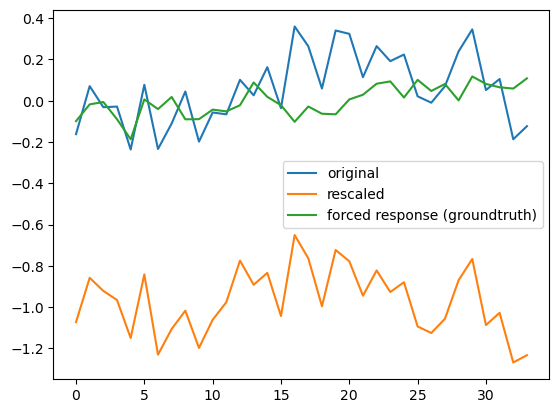

In [8]:
# sanity check about the rescaled data
idx_cell = 100
idx_run = 2
plt.close('all')
fig, ax = plt.subplots()
ax.plot(x_rescaled_tmp[m0][idx_run,:,notnan_idx[idx_cell]].detach().numpy(),label='original')
ax.plot(x_rescaled[m0][idx_run,:,notnan_idx[idx_cell]].detach().numpy(),label='rescaled')
# ax.plot(y_pred_ridge[idx_run,:,notnan_idx[idx_cell]].detach().numpy(),label='forced response (ridge)')
ax.plot(y_rescaled[m0][idx_run,:,notnan_idx[idx_cell]].detach().numpy(),label='forced response (groundtruth)')
ax.legend()
plt.show()


In [7]:
print(torch.nansum((x_rescaled_tmp[m0] - x_rescaled[m0])**2))
print(torch.nansum((y_rescaled[m0] - x_rescaled[m0])**2))
print(torch.nansum((x_rescaled_tmp[m0] - y_rescaled[m0])**2))

tensor(428588.2500)
tensor(460519.0625)
tensor(31930.7695)
